Gaussian processes demo

In [2]:
import numpy as np
import matplotlib.pylab as plt
import vtk
import vtkplotlib as vpl
from vtk.util.numpy_support import vtk_to_numpy
import os
from scipy import spatial

In [5]:
def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)

def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

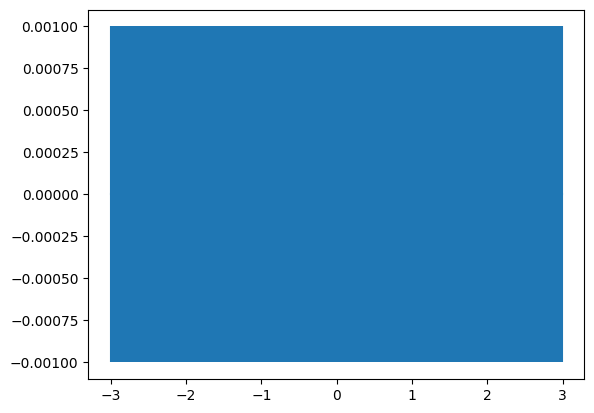

In [3]:

θ = [0.001, 2.5]
σ_0 = exponential_cov(0, 0, θ)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=σ_0, capsize=0)
plt.show()

In [4]:
"""x = np.linspace(-3, 3, 20)
#y = [np.random.normal(scale=σ_0) for _ in x]
y = np.sin(2*x) + np.random.normal(0, 0.2, x.shape)
plt.plot(x, y, 'ro')
plt.show()"""

"x = np.linspace(-3, 3, 20)\n#y = [np.random.normal(scale=σ_0) for _ in x]\ny = np.sin(2*x) + np.random.normal(0, 0.2, x.shape)\nplt.plot(x, y, 'ro')\nplt.show()"

In [5]:
x = [1.]
y = [np.random.normal(scale=σ_0)]
print(y)

[0.0004176531702014464]


In [6]:
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

σ_1 = exponential_cov(x, x, θ)
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, θ, σ_1, y) for i in x_pred]

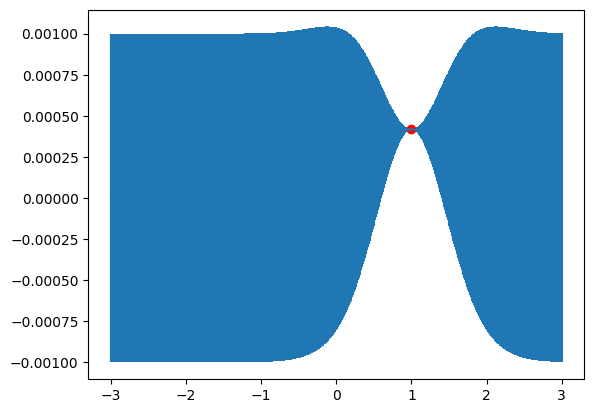

In [7]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.show()

In [8]:
m, s = conditional([-0.7], x, y, θ)
y2 = np.random.normal(m, s)
print(y2)

0.00020452948352969695


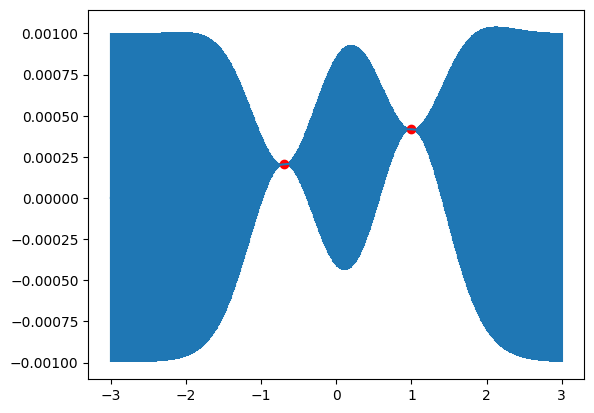

In [9]:
x.append(-0.7)
y.append(y2)
σ_2 = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_2, y) for i in x_pred]

y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.show()

In [10]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, θ)
y_more = np.random.multivariate_normal(mu, s)
print(y_more)

[-0.01463139  0.00598405  0.01240586 -0.01695549 -0.01709121]


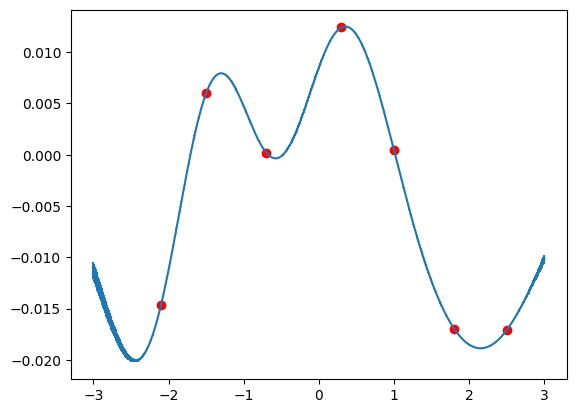

In [11]:
x += x_more
y += y_more.tolist()
σ_new = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_new, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.show()

Fitting Gaussian processes into the data 

In [4]:
from sklearn import gaussian_process 
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor

In [13]:
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

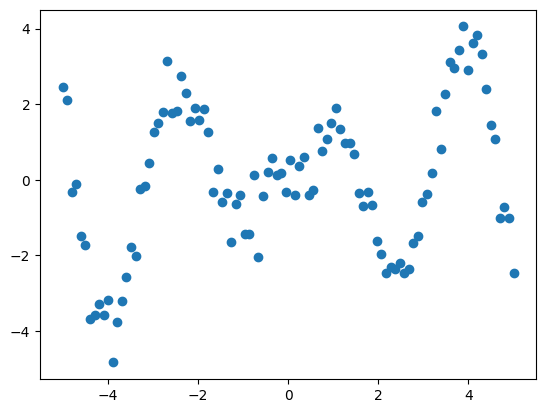

In [14]:
N = 100
x = np.linspace(-5, 5, N)

Y = x*np.sin(2*abs(x)) + np.random.normal(0, 0.5, N)
plt.scatter(x, Y)
plt.show()

In [15]:
X = x.reshape(-1, 1)
print(X.shape)

(100, 1)


In [16]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X, Y)
GaussianProcessRegressor(alpha=1e-15, copy_X_train=True,
kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
n_restarts_optimizer=0, normalize_y=False,
optimizer='fmin_l_bfgs_b', random_state=None)

c:\RoboDK\Python37\lib\site-packages\sklearn\gaussian_process\kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


GaussianProcessRegressor(alpha=1e-15,
                         kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1))

In [17]:
x_pred = np.linspace(-5, 5, 2*N).reshape(-1,1)
y_pred, sigma = gp.predict(x_pred, return_std=True)
x_pred.shape, y_pred.shape, sigma.shape

((200, 1), (200,), (200,))

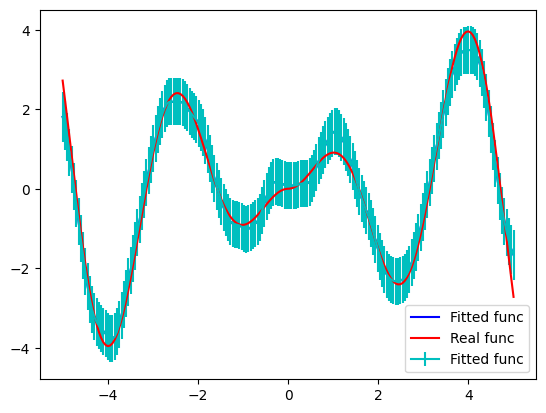

In [18]:
plt.plot(x_pred[:, 0], y_pred, "b", label='Fitted func')
plt.errorbar(x_pred[:, 0], y_pred, yerr=sigma, capsize=0, label='Fitted func', c='c')
plt.plot(x_pred[:, 0], x_pred[:, 0]*np.sin(2*abs(x_pred[:, 0])), "r", label='Real func')

plt.legend()
plt.show()

Application on Faces dataset

In [3]:
def readfile(filename):
    reader = vtk.vtkGenericDataObjectReader()
    reader.SetFileName(filename)
    reader.Update()

    polydata = reader.GetOutput()

    points = polydata.GetPoints()
    array = points.GetData()
    numpy_nodes = vtk_to_numpy(array)
    #print(numpy_nodes)
    cells = polydata.GetPolys()
    nCells = cells.GetNumberOfCells()
    array = cells.GetData()
    # This holds true if all polys are of the same kind, e.g. triangles.
    assert(array.GetNumberOfValues()%nCells==0)
    nCols = array.GetNumberOfValues()//nCells
    numpy_cells = vtk_to_numpy(array)
    numpy_cells = numpy_cells.reshape((-1,nCols))
    return numpy_cells, numpy_nodes

def write_vtk(points, cell, filename):
    with open(filename, 'w') as f:
        # Write header
        f.write("# vtk DataFile Version 4.2\n")
        f.write("vtk output\n")
        f.write("ASCII\n")
        f.write("DATASET POLYDATA\n")
        
        # Write points
        num_points = len(points)
        f.write("POINTS {} float\n".format(num_points))
        for point in points:
            f.write("{} {} {}\n".format(point[0], point[1], point[2]))
        
        # Write cells
        num_cells = len(cell)
        total_num_points = np.sum(cell[:, 0])
        f.write("POLYGONS {} {}\n".format(num_cells, total_num_points + num_cells))
        for cell_indices in cell:
            num_indices = cell_indices[0]
            f.write("{} ".format(num_indices))
            for index in cell_indices[1:]:
                f.write("{} ".format(index))
            f.write("\n")

def visualize(nameOfFile):

        # Load the VTK file
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(nameOfFile)
    reader.Update()

    # Create a mapper
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(reader.GetOutputPort())

    # Create an actor
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)

    # Create a renderer and add the actor to it
    renderer = vtk.vtkRenderer()
    renderer.AddActor(actor)

    # Create a render window and set the renderer as its active renderer
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(600, 600)
    renderer.ResetCamera()

    # Create an interactor and start the visualization
    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(renderWindow)
    interactor.Start()

def flatten(Shape):
    return np.concatenate((Shape[:, 0], Shape[:, 1], Shape[:, 2]))

def unflatten(Shape):
    n = len(Shape)//3
    return np.array([Shape[:n], Shape[n:2*n], Shape[2*n:]]).T

def My_Visualize(Faces_List=[], Wiring=[], colors=[], Scatter=[0]):
    mesh = Faces_List[0][Wiring][:, 1:]
    offset = np.zeros(mesh.shape)
    vpl.figure("Face")
    for i in range(len(Faces_List)) :
        mesh = Faces_List[i][Wiring][:, 1:] + offset
        vpl.mesh_plot(mesh, color=colors[i])
        offset[:, :, 0] += 0.01
    if Scatter[0]:
        vpl.scatter(Faces_List[0][Scatter], radius=0.0001, color='r')
    vpl.show()

In [4]:
## Insert the path to faces files
path = '../Aligned_data/'

L = os.listdir(path)
Dataset = []
Wiring = []

for f in L :
    if 'vtk' in f :
       Tab, Tob = readfile(path+f)
       Dataset.append(Tob.flatten())
       Wiring.append(Tab)
    #My_Visualize([Tob], Tab, ['w'])
Dataset = np.array(Dataset[:-1])
Dataset.shape

(10, 159447)

In [5]:
def Region(T, center, radius):
    Indexes = []
    for i in range(len(T)) :
        if np.linalg.norm(T[i]-center)<radius :
            Indexes.append(i)
    return Indexes

In [6]:
path = '../Aligned_data/'

Indexes = []
Tab = []
for f in L :
    if 'vtk' in f :
       Tab, Tob = readfile(path+f)
       Indexes = Region(Tob, [0.0005, 0.0012, 0.004], 0.00135)
       print(len(Indexes))
       My_Visualize([Tob], Tab, ['w'], Indexes)
    break

854


In [7]:
Mean_shape = np.mean(Dataset, axis=0)
Dataset = Dataset - Mean_shape
Mean_shape.shape


(159447,)

In [8]:
N_process = 18

Decoding = []

for j in range(N_process) :
    L = []
    for i in range(Dataset.shape[1]) :
        if i%N_process == j :
            L.append(i)
    Decoding.append(L)

#Decoding = np.array(Decoding)
print(len(Decoding))
    

18


In [9]:
Train_data = Dataset[:9, :]
Test_data = Dataset[9, :]

Train_data.shape, Test_data.shape

((9, 159447), (159447,))

In [10]:
"""Distributed_training = []

for i in range(N_process) :
    Distributed_training.append(Train_data[:, Decoding[i]])

Distributed_training = np.array(Distributed_training)
Distributed_training.shape"""

def expe_cov(A, s, sigma) :
    return s*np.exp(-(A**2)/(sigma**2))

In [11]:
#Cov_matrices = np.zeros((N_process, Decoding.shape[1], Decoding.shape[1]))

Cov_matrices = [np.zeros((len(Decoding[i]), len(Decoding[i]))) for i in range(N_process)]

In [12]:

s = 4e-8
sigma = 0.0001
for i in range(N_process):
    Cov_matrices[i] = expe_cov(spatial.distance.cdist(Mean_shape[Decoding[i][:]].reshape(-1, 1), Mean_shape[Decoding[i][:]].reshape(-1, 1)), s, sigma)

In [13]:
from copy import deepcopy

#Regions_decod = np.zeros(Decoding.shape)
Regions_decod = deepcopy(Decoding)
#print(Regions_decod.shape)

for i in range(len(Regions_decod)) :
    for j in range(len(Regions_decod[i])) :
        if (Decoding[i][j]//3 in Indexes) :
            Regions_decod[i][j] = 0 
        else :
            Regions_decod[i][j] = 1

In [14]:
cov_i = 0

l = 1000
k = 1500

for i in range(Train_data.shape[0]) :
    cov_i += Train_data[i, l]*Train_data[i, k]

cov_i /= Train_data.shape[0]
cov_i

1.1632120394215277e-09

In [15]:
Posterior_dists = []

for j in range(N_process) :
    print(j)
    mu = Cov_matrices[j][np.array(Regions_decod[j])==0, :][:, np.array(Regions_decod[j])==1] @ np.linalg.inv(Cov_matrices[j][np.array(Regions_decod[j])==1, :][:, np.array(Regions_decod[j])==1]) @ Test_data[np.array(Decoding[j])[np.array(Regions_decod[j])==1]]
    Posterior_dists.append(mu)
    break

0


In [16]:
Prediction = np.zeros(Test_data.shape)

for j in range(N_process) :
    Prediction[np.array(Decoding[j])[np.array(Regions_decod[j])==1]] = Test_data[np.array(Decoding[j])[np.array(Regions_decod[j])==1]]
for j in range(N_process) :
    Prediction[np.array(Decoding[j])[np.array(Regions_decod[j])==0]] = Posterior_dists[j]/(1000000000*np.max(Posterior_dists[j]))

Prediction += Mean_shape

IndexError: list index out of range

In [34]:


def unflatten(Mesh) : 
    Shape = np.zeros((len(Mesh)//3, 3))
    for i in range(Shape.shape[0]): 
        Shape[i] = Mesh[3*i:3*(i+1)]
    return Shape

N_shape = deepcopy(Mean_shape)
for j in range(N_process) :
    N_shape[np.array(Decoding[j])[np.array(Regions_decod[j])==0]] = 0
#Shape = unflatten(Prediction)

My_Visualize([unflatten(N_shape)], Tab, ['w'])

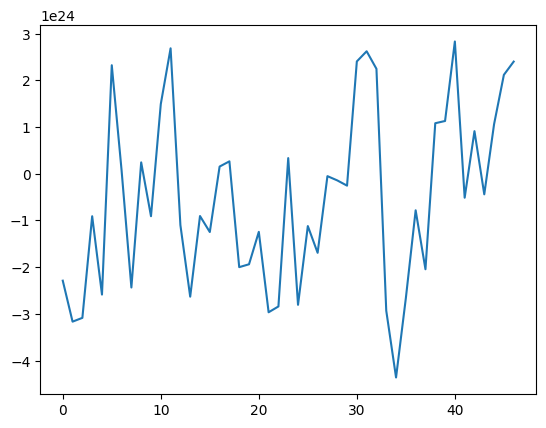

In [ ]:
L = [7]
plt.plot(Posterior_dists[6])
plt.show()